In [296]:
#from typing import Match

import numpy as np
import matplotlib
import matplotlib.pyplot as plt # para plots
import itertools


### Gerando nosso Dataset ###

In [297]:

# Função que define a equação diferencial
def EDO_pendulo(t, y):
    theta, d_theta_dt = y
    dd_theta_dt = - (g / L) * np.sin(theta)
    return [d_theta_dt, dd_theta_dt]

def generate_data_set(omega = 1, theta = 0, time_parameters =[] ):
    t_0,t_end,dt = time_parameters    
    # Método de Euler para resolver a EDO
    t_values = np.arange(t_0, t_end, dt)

    theta_values = []
    omega_values = []
    for t in t_values:
        theta_values.append(theta)
        omega_values.append(omega)
        
        # Método de Euler
        dtheta_dt, domega_dt = EDO_pendulo(t, [theta, omega])
        theta += dtheta_dt * dt
        omega += domega_dt * dt

    # Converter o deslocamento angular para coordenadas x-y
    x_values = L * np.sin(theta_values)
    y_values = -L * np.cos(theta_values)
    return [x_values,y_values]

def plot_Pendulum(data):
    x_values, y_values = data 
    # Plotagem
    plt.plot(x_values, y_values)
    plt.xlabel('x (t)')
    plt.ylabel('y (t)')
    plt.title('Movimento do Pêndulo Simples')
    plt.grid(True)
    plt.axis('equal')
    plt.show()



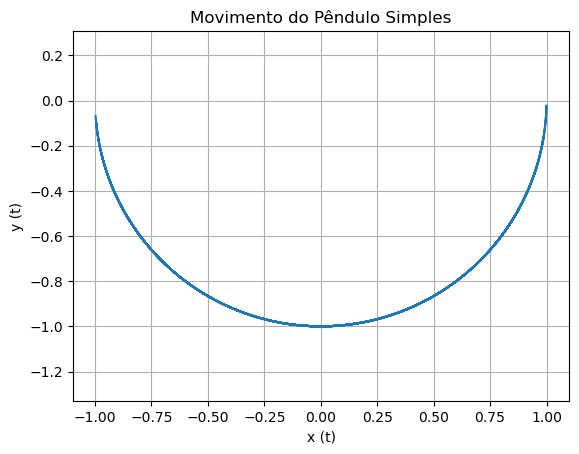

In [298]:

# Constantes
global g, L, phi, omega_0
g = 9.81  # m/s^2, aceleração devido à gravidade
L = 1.0   # m, comprimento do pêndulo
phi = np.pi / 3  # Ângulo inicial em radianos
omega_0 = 0.0        # Velocidade angular inicial

# Parâmetros de tempo
N=1000 # Numero de pontos
t_0 = 0.0            # Tempo inicial
t_end = 10.0         # Tempo final
dt = t_end/N            # Tamanho do passo de tempo
time_parameters = [t_0,t_end,dt]

# Condições iniciais
theta = phi 
omega = omega_0

data = generate_data_set(omega, theta, time_parameters)
plot_Pendulum(data)


### Usando o perceptron para adquirir informação sobre o sistema 


Suponha agora que só há o data set como entrada, ou seja, não temmos mais informação do que a imagem plotada acima. Vamos usar o perceptron para verificar se conseguimos adquirir informação sobre a fase e frequencia do nosso pendulo apenas alimentando a rede com $(x,y)$ . 

A ideia é o perceptron ter como input $(x,y)$ , e como output $\sin(theta)$. Idealmente, $\theta$ tem a forma

 $x*w1 + y*w_2 + b = \theta$ 

idealmente, como somente $x,y$ mudam com o tempo $t$, então, podemos associar 

$x*w1 + y*w_2 = \omega*t,  \quad \text{e} \quad b = \varphi_0$ 

In [299]:

# definindo funções do perceptron

def perceptron(y_in = [], w=[], b=[]) :
    z_in = np.dot(y_in,w) + b
    z_out = activation(z_in)
    z_out_y = -np.sqrt(1-z_out**2)
    dif = dif_activation(z_in)
    return [np.concatenate((z_out,z_out_y)), dif ]

def activation(z=0):
    return np.sin(z)
    #return 1/(1+np.exp(-z)) 
                
# definindo derivada da função custo (será util para o treino)
def dif_activation(z):
    return np.cos(z)
    #return 1/((1+np.exp(-z))*(1+np.exp(z))) 

#def sigmoid (z=0):
#    return 1/(1 + np.exp(-z))

def create_RandomWeights_perceptron(Ns =[]):
    ''' cria pesos e bias aleatorios para o perceptron.
    '''
    w = np.random.uniform(low=-3,high=3,size=(2,))
    b = np.random.uniform(low=-np.pi,high=np.pi,size=(1))
    return [w,b]

def Loss_function(z_out, z_real):
    return sum((z_out - z_real)**2)# + ((b-phi)**2)[0]



#### Alguns resultados com inicialização aleatória e sem treinamento

In [300]:
# preparando os pesos e bias
W, b = create_RandomWeights_perceptron([])
global b
# verificando um output para incialização aleatoria
x_0, y_0 = data[0][0], data[1][0]
z_out,dif = perceptron([x_0,y_0], W,b)

loss = Loss_function(z_out,[x_0,y_0])


#vamos ver alguns valores
print(f'z_out = sin(w1*x_0 + w2*y_0 +b) =  {z_out[0]}')
print(f'z_out_y = -cos(1*x_0 + w2*y_0 +b) = {z_out[1]}')
print(f'x,y esperados = {x_0}, {y_0} \n')
print(f'Loss = {loss}\n')
print(f'W = {W}')
print(f'b = {b}')

z_out = sin(w1*x_0 + w2*y_0 +b) =  0.1113007009879065
z_out_y = -cos(1*x_0 + w2*y_0 +b) = -0.9937867748967083
x,y esperados = 0.8660254037844386, -0.5000000000000001 

Loss = 0.8134347560742061

W = [ 2.81050925 -0.17672089]
b = [0.50772801]


#### Definindo funções de treinamento (backpropagation)

In [301]:
def backpropagation_perceptron(delta,w,df):
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( np.dot(delta,np.transpose(w))*df )

def treinamento_perceptron_1Passo(data, W,b, Epochs, lr):
    # verificando um output para incialização aleatoria
    loss = np.zeros(Epochs)
    x_0, y_0 = data[0][0], data[1][0]
    z_out,dif = perceptron([x_0,y_0], W,b)
    loss[0] = Loss_function(z_out,[x_0,y_0])
    
    # calculando passo do gradiente
    grad = (z_out - [x_0,y_0]) 
    delta = np.dot(grad,W)*dif
    grad_step = np.transpose(delta*[x_0,y_0])
    
    # atualizando valores
    W = W - lr*grad_step
    b = b - lr*delta

    x_0, y_0 = data[0][0], data[1][0]
    z_out,dif = perceptron([x_0,y_0], W,b)
    loss[1] = Loss_function(z_out,[x_0,y_0])
    return loss

def treinamento_perceptron(data, W,b, Epochs, lr):
    # verificando um output para incialização aleatoria
    loss = np.zeros(Epochs)

    for j in range(Epochs):
        x, y = data[0][j], data[1][j]
        z_out,dif = perceptron([x_0,y_0], W,b)
        loss[j] = Loss_function(z_out,[x,y])
        # calculando passo do gradiente
        grad = (z_out - [x,y]) 
        delta = np.dot(grad,W)*dif
        grad_step = np.transpose(delta*[x,y])
        
        # atualizando valores
        W = W - lr*grad_step
        b = b - lr*delta
    return loss
    



In [302]:
# preparando os pesos e bias iniciais
global data2
W, b = create_RandomWeights_perceptron([])

# verificando um output para incialização aleatoria
x_0, y_0 = data[0][0], data[1][0]
z_out= perceptron([x_0,y_0], W,b)[0]

loss = Loss_function(z_out,[x_0,y_0])

Epochs =1000
loss = treinamento_perceptron(data, W,b, Epochs, lr=0.1)

data2 = np.zeros((2,N))
for j in range(N):
    data2[0,j], data2[1,j]  = perceptron([data[0][j],data[1][j]], W,b)[0]
#plot_Pendulum(data2)

z_out= perceptron([x_0,y_0], W,b)[0]

#vamos ver alguns valores
print(f'z_out = sin(w1*x_0 + w2*y_0 +b) =  {z_out[0]}')
print(f'z_out_y = -cos(1*x_0 + w2*y_0 +b) = {z_out[1]}')
print(f'x,y esperados = {x_0}, {y_0} \n')
print(f'Loss = {loss[-1]}\n')
print(f'W = {W}')
print(f'b = {b} = phi? = {phi}\n')
print(f'omega = {np.dot(W,[data[0][0], data[1][0]])} ')

z_out = sin(w1*x_0 + w2*y_0 +b) =  0.8745902993222977
z_out_y = -cos(1*x_0 + w2*y_0 +b) = -0.4848626695584366
x,y esperados = 0.8660254037844386, -0.5000000000000001 

Loss = 3.995361652927589

W = [-1.78201912 -0.56890224]
b = [-2.94736013] = phi? = 1.0471975511965976

omega = -1.2588227124585745 


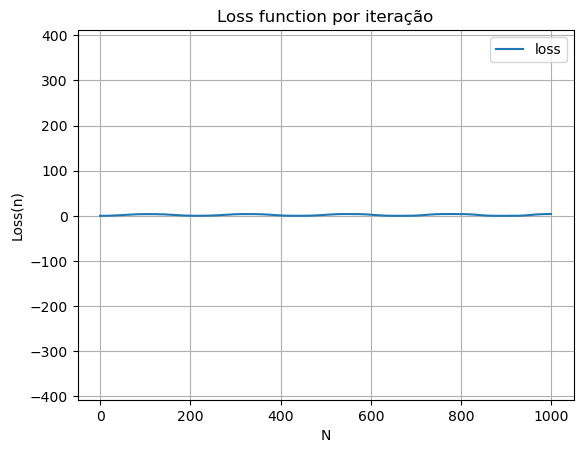

In [303]:
plt.plot(range(N), loss, label = 'loss')
plt.xlabel('N')
plt.ylabel('Loss(n)')
plt.title('Loss function por iteração')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

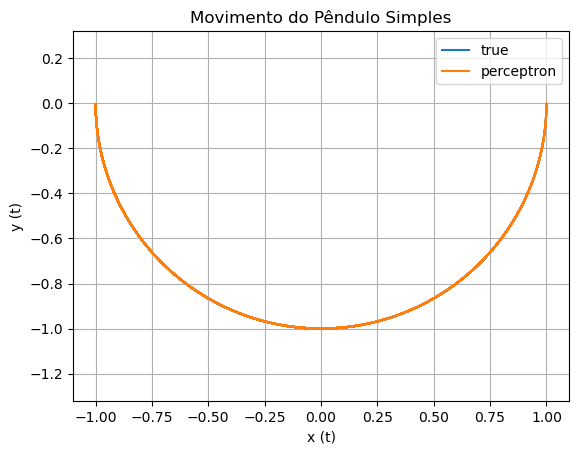

In [304]:
x_values, y_values = data 
x_values2, y_values2 = data2 
# Plotagem
plt.plot(x_values, y_values, label = 'true')
plt.xlabel('x (t)')
plt.ylabel('y (t)')
plt.title('Movimento do Pêndulo Simples')
plt.grid(True)
plt.axis('equal')
plt.plot(x_values2, y_values2, label = 'perceptron')
plt.legend()
plt.show()